# Helper Functions

In [1]:
def get_pdf(data):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    
    kde = gaussian_kde(data)

    return kde    

In [2]:
def plot_pdf(data, label='', x_axis=''):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    
    # create two subplots
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("Probability Distribution and Historgram "+label)
    
    #create the kernel, which estimates the probability over the values in the array
    kde = gaussian_kde(data)
    
    #these are the values over wich your kernel will be evaluated
    dist_space = linspace(min(data),max(data), 100)

    # plot the results
    axs[0].plot(dist_space, kde(dist_space))
    axs[0].set_ylabel('probability')
    axs[0].set_xlabel(x_axis)
    axs[1].hist(data)
    axs[1].set_ylabel('histogram')
    axs[1].set_xlabel('x_axis')
    plt.show()

In [3]:
def get_dist(df, var='age', bucket_size=5, to_print=False):
    import math
    
    # create an array that holds the counts of different age groups in bucket_size 
    arr = [];
    for x in range(0,100,bucket_size):
        arr.append(0)
    
    # go through the data, look at each age and update counter for that age group
    for x in df[var]:
        index = math.floor(x/bucket_size)
        arr[index] = arr[index] + 1;

    if to_print:
        age = 0;
        # print the array
        for x in arr:
            print(str(age) + "-" + str(age+bucket_size), ": ", x)
            age = age + bucket_size
    
    return arr

In [4]:
def find_new_len(len_df_one, dist_one, len_df_two, dist_two):
    import math 
    
    new_len = len_df_one

    for precision in np.arange(1, 0, -0.05):
        new_len = len_df_one
        for i in range(len(dist_one)):
            if dist_one[i] < (new_len*dist_two[i]/len_df_two)*precision:
                if dist_one[i] != 0:
                    new_len = math.floor(dist_one[i]*len_df_two/dist_two[i])
                else:
                    new_len = new_len - (new_len*dist_two[i]/len_df_two)
        if new_len >= 50:
            print("New Length: ", new_len, " with Precision: ", precision)
            break
            
    return new_len

In [5]:
def match_dist(df_to, df_from, var='age', var_1 = 'subject', bucket_size=3):
    import math 
    
    df_new = pd.DataFrame([])
    
    # sort the dataframes
    df_to = df_to.sort_values(by=var)
    df_from = df_from.sort_values(by=var)
    
    # get the distributions from both
    dist_to = get_dist(df_to, bucket_size=bucket_size)
    dist_from = get_dist(df_from, bucket_size=bucket_size)
    
    index = 0
    i = 0
    rand_subj = []
    
    # calculate the size of the new dataset that would allow for the same distribution as the dataset being mimicked
    df_new_length = find_new_len(len(df_to), dist_to, len(df_from), dist_from)
    
    # go through the number of subjects in the age range of the resampling data
    for x in np.arange(0, 100, bucket_size):
        subj_bucket = []
        
        # get all the subjects in the age range of the resampling data
        for j in range(dist_to[i]):
            subj_bucket.append((df_to[var_1])[index+j])

        index = index + dist_to[i]
        
        # get the number of subjects in the data that is being mimicked
        num_rand = math.floor(df_new_length * (dist_from[i]/len(df_from)))
        
        if not len(subj_bucket) == 0:
            # choose random subjects from subject bucket
            # the number of random subjects chosen depends on the distributions
            rand_subj = []
            
            if dist_to[i] < num_rand:
                rand_subj = np.random.choice(subj_bucket, size=dist_to[i], replace=False)
            else:
                rand_subj = np.random.choice(subj_bucket, size=num_rand, replace=False)
        
        for sub in rand_subj:
                temp = pd.DataFrame(df_to[df_to[var_1] == sub])
                df_new = pd.concat([df_new, df_to[df_to[var_1] == sub]])

        # increment index for age distribution array
        i = i+1
    
    return df_new

In [6]:
def sample(df_to, df_from, title_to='', title_from='', var='age', var_1='subject', bucket_size=3):
    from scipy import stats

    plot_pdf(df_from[var], title_from, var)
    plot_pdf(df_to[var], title_to , var)
    
    # sample from original
    df_sample = match_dist(df_to, df_from, bucket_size = bucket_size)
    print("Actual Length: ", len(df_sample))
    print(df_sample.head())
    
    # plot new probability density function
    plot_pdf(df_sample[var], title_to + ":" + title_from, var)
    
    # test if the two distributions would be the same
    print("stats: ", stats.ks_2samp(df_sample[var], df_from[var]))
    
    return df_sample

# Hypothesis #1

Research Question:
If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

## Setup

In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import subprocess
from datetime import date
import re
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [8]:
# project directory
project_dir = Path('/data/NNDSP')

# NNDSP data directories
nndsp_bids_dir = Path('/data/NNDSP/bids_2017_07_14_generic')
nndsp_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
nndsp_bar_dir = Path('/data/NNDSP/derivatives/bar_subj')
nndsp_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/NNDSP_famid.csv')

# HCP data directories
hcp_bids_dir = Path('/data/HCP/HCP_900/s3/hcp')
hcp_fs_dir = Path('/data/NNDSP/derivatives/fs_hcp_subj')
hcp_bar_dir = Path('/data/NNDSP/derivatives/bar_hcp_subj')
hcp_pheno_file = Path('/data/NNDSP/nino/HCP_ages.csv')

# NKI data directories
nki_bids_dir = Path('/data/NNDSP/anal/NKI')
nki_fs_dir = Path('/data/NNDSP/derivatives/fs_nki_subj')
nki_bar_dir = Path('/data/NNDSP/derivatives/bar_nki_subj')
nki_pheno_file = Path('/data/NNDSP/anal/analysis_notebooks/phenotype_files/participants.tsv')

# CoRR data directories
corr_bids_dir = Path('/data/DSST/CoRR/bids_corr')
corr_fs_dir = Path('/data/DSST/CoRR/fs_corr')
#corr_bar_dir
corr_pheno_file = Path('/data/DSST/CoRR/phenotype_files/corr_ages.csv')

# SALD data directories
sald_bids_dir = Path('/data/DSST/SALD/bids_sald')
# sald_fs_dir = Path('/data/NNDSP/derivatives/fs5.3_subj')
# sald_bar_dir
sald_pheno_file = Path('/data/DSST/SALD/phenotype_files/sub_information.xlsx')

## NNDSP Subject Data

In [9]:
# merge the subjects that we have fs and add subject number
df_nndsp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nndsp_fs_dir.glob('sub-*')]})
df_nndsp = df_nndsp.assign(MASKID = [int(Path(x).name[4:]) for x in df_nndsp.subj_paths])
df_nndsp.head()

,subj_paths,MASKID
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371


In [10]:
# merge the subjects we have fs of with their ages
df_nndsp = pd.merge(df_nndsp, pd.read_csv(nndsp_pheno_file.as_posix()), on='MASKID')

In [11]:
# rename columns so that we have standardization across datasets
df_nndsp = df_nndsp.rename(index=str, columns = {'MASKID' : 'subject', 'age_at_scan' : 'age'})
df_nndsp = df_nndsp.drop_duplicates(subset='subject', keep='first')
df_nndsp.head()

,subj_paths,subject,MRN,nuclear_fam_id,Sex,age
0,/data/NNDSP/derivatives/fs5.3_subj/sub-1889,1889,7135075,10230,Female,9.667351
1,/data/NNDSP/derivatives/fs5.3_subj/sub-2011,2011,7078997,10109,Male,18.310746
2,/data/NNDSP/derivatives/fs5.3_subj/sub-1948,1948,4571265,1854,Female,14.269678
3,/data/NNDSP/derivatives/fs5.3_subj/sub-1198,1198,4359628,1613,Male,14.390144
4,/data/NNDSP/derivatives/fs5.3_subj/sub-1371,1371,7218874,10286,Male,16.621492


## HCP Subject Data

In [12]:
# merge the subjects that we have fs and add subject number
df_hcp = pd.DataFrame({'subj_paths' : [x.as_posix() for x in hcp_fs_dir.glob('sub-*')]})
df_hcp = df_hcp.assign(Subject = [int(Path(x).name[4:]) for x in df_hcp.subj_paths])
df_hcp.head()

,subj_paths,Subject
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441


In [13]:
# merge the subjects we have fs of with their ages
df_hcp = pd.merge(df_hcp, pd.read_csv(hcp_pheno_file.as_posix()), on='Subject')

In [14]:
# rename columns so that we have standardization across datasets
df_hcp = df_hcp.rename(index=str, columns={'Subject' : 'subject', 'Age_in_Yrs' : 'age'})
df_hcp = df_hcp.drop_duplicates(subset='subject', keep='first')
df_hcp.head()

,subj_paths,subject,age,HasGT,ZygositySR,ZygosityGT,Family_ID,Mother_ID,Father_ID,TestRetestInterval,...,SSAGA_Times_Used_Illicits,SSAGA_Times_Used_Cocaine,SSAGA_Times_Used_Hallucinogens,SSAGA_Times_Used_Opiates,SSAGA_Times_Used_Sedatives,SSAGA_Times_Used_Stimulants,SSAGA_Mj_Use,SSAGA_Mj_Ab_Dep,SSAGA_Mj_Age_1st_Use,SSAGA_Mj_Times_Used
0,/data/NNDSP/derivatives/fs_hcp_subj/sub-749361,749361,29,True,NotTwin,,52442_82285,52442,82285,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0
1,/data/NNDSP/derivatives/fs_hcp_subj/sub-191942,191942,27,True,NotTwin,,56029_85850,56029,85850,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
2,/data/NNDSP/derivatives/fs_hcp_subj/sub-983773,983773,28,True,NotTwin,,52801_82622,52801,82622,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
3,/data/NNDSP/derivatives/fs_hcp_subj/sub-387959,387959,26,True,NotMZ,,55795_85616,55795,85616,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
4,/data/NNDSP/derivatives/fs_hcp_subj/sub-193441,193441,28,True,NotTwin,,52875_82697,52875,82697,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


## NKI Subject Data

In [15]:
# merge the subjects that we have fs and add subject number
df_nki = pd.DataFrame({'subj_paths' : [x.as_posix() for x in nki_fs_dir.glob('sub-*')]})
df_nki = df_nki.assign(participant_id = [Path(x).name[4:13] for x in df_nki.subj_paths])
df_nki.head()

,subj_paths,participant_id
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087
2,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236
3,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003


In [16]:
# merge the subjects that we have fs with age
df_nki = pd.merge(df_nki, pd.read_csv(nki_pheno_file.as_posix(), sep='\t'), on='participant_id')

In [17]:
# rename so that we have standardization across datasets
df_nki = df_nki.rename(index=str, columns={'participant_id' : 'subject', 'age' : 'age'})
df_nki = df_nki.drop_duplicates(subset='subject', keep='first')
df_nki.head()

,subj_paths,subject,age,sex,handedness
0,/data/NNDSP/derivatives/fs_nki_subj/sub-A00023510,A00023510,23.0,MALE,RIGHT
1,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066087,22.0,MALE,RIGHT
4,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066236,33.0,MALE,RIGHT
7,/data/NNDSP/derivatives/fs_nki_subj/sub-A00034350,A00034350,11.0,MALE,RIGHT
8,/data/NNDSP/derivatives/fs_nki_subj/sub-A00063003,A00063003,13.0,MALE,RIGHT


## CoRR Subject Data

In [18]:
# merge the subjects that we have fs and add subject number
df_corr = pd.DataFrame({'subj_paths' : [x.as_posix() for x in corr_fs_dir.glob('sub-*')]})
df_corr = df_corr.assign(SUBID = [int(Path(x).name[4:11]) for x in df_corr.subj_paths])
df_corr.head()

,subj_paths,SUBID
0,/data/DSST/CoRR/fs_corr/sub-0025482,25482
1,/data/DSST/CoRR/fs_corr/sub-0003057,3057
2,/data/DSST/CoRR/fs_corr/sub-0026120_ses-2,26120
3,/data/DSST/CoRR/fs_corr/sub-0025728_ses-2.long...,25728
4,/data/DSST/CoRR/fs_corr/sub-0025052,25052


In [19]:
# merge subjects with ages 
df_corr = pd.merge(df_corr, pd.read_csv(corr_pheno_file.as_posix()), on='SUBID')

In [20]:
# rename so that we have standardization across datasets
df_corr = df_corr.rename(index=str, columns={'SUBID' : 'subject', 'AGE_AT_SCAN_1' : 'age'})
df_corr = df_corr.sort_values(by='subj_paths')
df_corr = df_corr.drop_duplicates(subset='subject', keep='first')
df_corr.age = pd.to_numeric(df_corr.age, errors='coerce').fillna(0).astype(np.int64)
df_corr.head()

,subj_paths,subject,Unnamed: 0,age,SEX
3033,/data/DSST/CoRR/fs_corr/sub-0003001,3001,0,25,2
5380,/data/DSST/CoRR/fs_corr/sub-0003002,3002,2,23,1
5547,/data/DSST/CoRR/fs_corr/sub-0003004,3004,4,31,2
5338,/data/DSST/CoRR/fs_corr/sub-0003006,3006,6,23,1
5660,/data/DSST/CoRR/fs_corr/sub-0003007,3007,8,43,2


## SALD Subject Data

In [21]:
# complete once we have SALD FS files

## Sample NKI:NNDSP

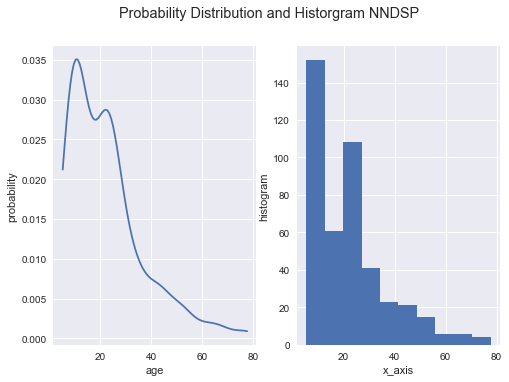

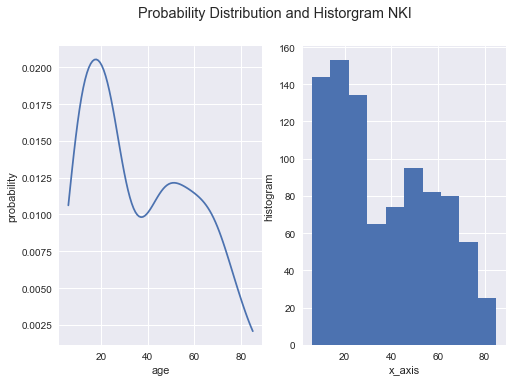

New Length:  329  with Precision:  1.0
Actual Length:  316
                                             subj_paths    subject  age  \
1206  /data/NNDSP/derivatives/fs_nki_subj/sub-A00066573  A00066573  7.0   
1191  /data/NNDSP/derivatives/fs_nki_subj/sub-A00057809  A00057809  8.0   
801   /data/NNDSP/derivatives/fs_nki_subj/sub-A00066534  A00066534  8.0   
1233  /data/NNDSP/derivatives/fs_nki_subj/sub-A00062349  A00062349  6.0   
367   /data/NNDSP/derivatives/fs_nki_subj/sub-A00066...  A00066860  7.0   

         sex handedness  
1206    MALE      RIGHT  
1191  FEMALE      RIGHT  
801     MALE       LEFT  
1233    MALE      RIGHT  
367   FEMALE      RIGHT  


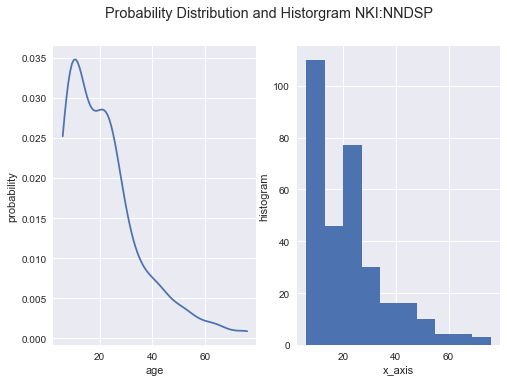

stats:  Ks_2sampResult(statistic=0.058366885844219785, pvalue=0.54757970226697372)


In [22]:
df_nki_nndsp = sample(df_nki, df_nndsp, title_to='NKI', title_from='NNDSP')

## Sample CoRR:NNDSP

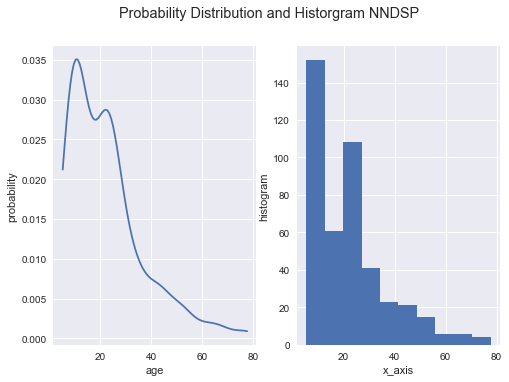

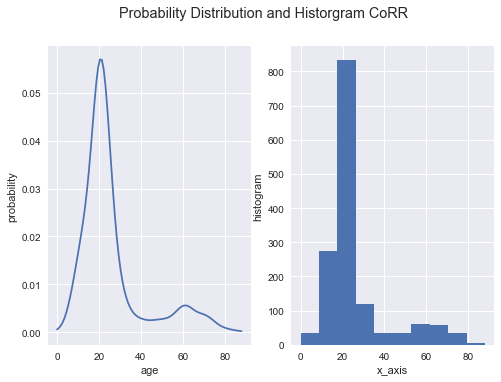

New Length:  187  with Precision:  1.0
Actual Length:  172
                               subj_paths  subject  Unnamed: 0  age SEX
499   /data/DSST/CoRR/fs_corr/sub-0026078    26078          64    6   2
5602  /data/DSST/CoRR/fs_corr/sub-0025074    25074         263    8   1
98    /data/DSST/CoRR/fs_corr/sub-0025013    25013          47    8   2
5344  /data/DSST/CoRR/fs_corr/sub-0025098    25098         311    7   1
4254  /data/DSST/CoRR/fs_corr/sub-0025002    25002           6    8   1


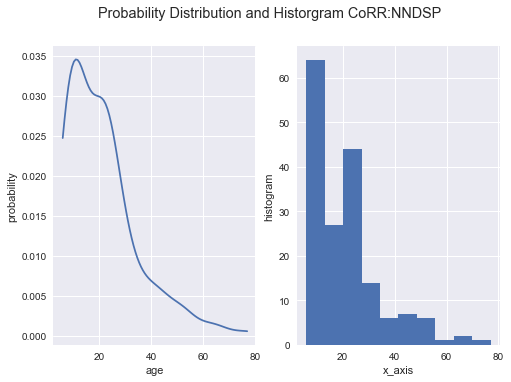

stats:  Ks_2sampResult(statistic=0.071044649034112006, pvalue=0.54658068756744083)


In [23]:
df_corr_nndsp = sample(df_corr, df_nndsp, title_to='CoRR', title_from='NNDSP', bucket_size=3)

## Sample SALD:NNDSP

## Sample NKI:HCP

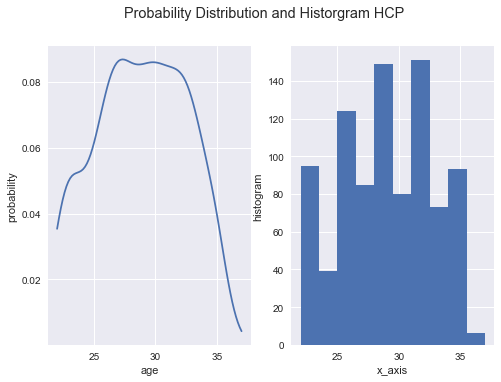

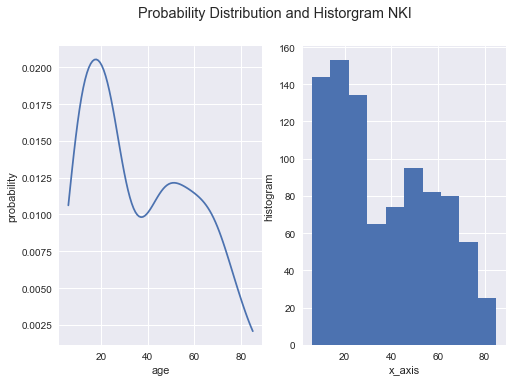

New Length:  94  with Precision:  1.0
Actual Length:  89
                                            subj_paths    subject   age  \
180  /data/NNDSP/derivatives/fs_nki_subj/sub-A00028606  A00028606  22.0   
493  /data/NNDSP/derivatives/fs_nki_subj/sub-A00066319  A00066319  23.0   
517  /data/NNDSP/derivatives/fs_nki_subj/sub-A00060...  A00060773  23.0   
222  /data/NNDSP/derivatives/fs_nki_subj/sub-A00057...  A00057786  22.0   
939  /data/NNDSP/derivatives/fs_nki_subj/sub-A00066...  A00066246  22.0   

        sex handedness  
180    MALE      RIGHT  
493  FEMALE      RIGHT  
517  FEMALE      RIGHT  
222  FEMALE      RIGHT  
939    MALE      RIGHT  


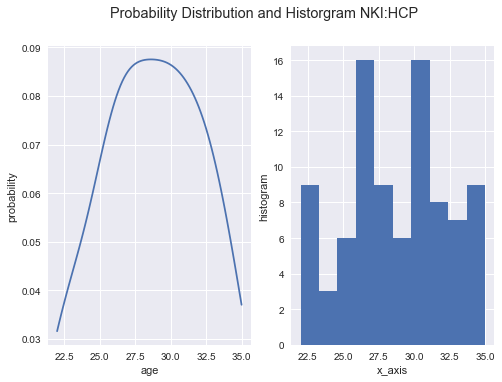

stats:  Ks_2sampResult(statistic=0.023815203063210055, pvalue=0.99999999994660871)


In [24]:
df_nki_hcp = sample(df_nki, df_hcp, title_to='NKI', title_from='HCP', bucket_size=2)

## Sample CoRR:HCP

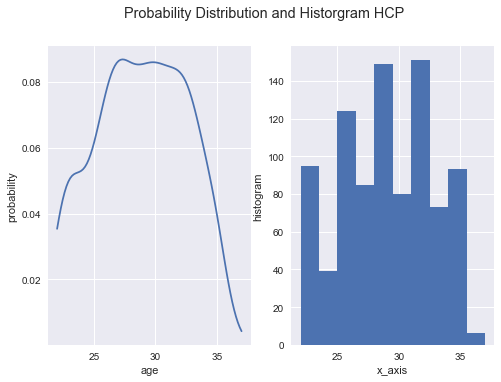

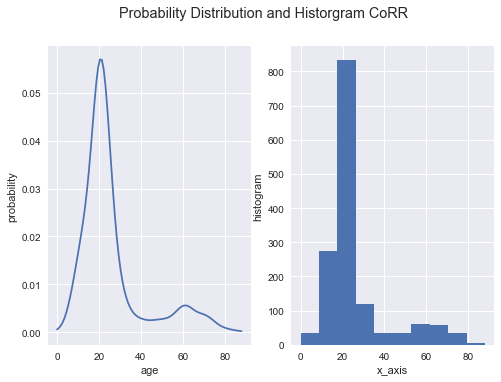

New Length:  97  with Precision:  1.0
Actual Length:  94
                               subj_paths  subject  Unnamed: 0  age SEX
163   /data/DSST/CoRR/fs_corr/sub-0025831    25831         114   21   2
1640  /data/DSST/CoRR/fs_corr/sub-0027194    27194          36   23   1
4014  /data/DSST/CoRR/fs_corr/sub-0025704    25704         310   21   2
5475  /data/DSST/CoRR/fs_corr/sub-0003063     3063         112   22   1
3316  /data/DSST/CoRR/fs_corr/sub-0025616    25616          34   22   1


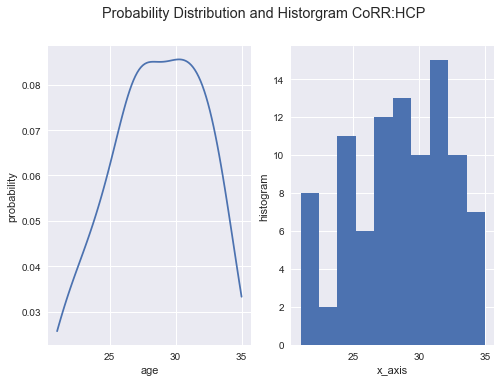

stats:  Ks_2sampResult(statistic=0.042648282420064187, pvalue=0.9972944785138943)


In [25]:
df_corr_hcp = sample(df_corr, df_hcp, title_to='CoRR', title_from='HCP', bucket_size=3)

## Sample SALD:HCP

In [48]:
%run /data/NNDSP/anal/analysis_notebooks/follow_up_analysis/util_models.ipynb

## Train NNDSP

In [27]:
scores_nndsp, nndsp_complex_train, nndsp_complex_test, nndsp_complex_pipes = complex_model(df_nndsp, nndsp_bar_dir)

Complex Source 431
Mean Absolute Error (Train, thickness): 0.0990106091605
Mean Absolute Error (Test, thickness): 5.67815490273
Complex Source 431


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, aseg): 4.16920755674
Mean Absolute Error (Test, aseg): 5.0251044866
Complex Source 431


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.0996503673993
Mean Absolute Error (Test, area): 6.70457294628
Fitting stacking model
best max_depth: 4
Mean Absolute Error (Train): 2.98660366864
Mean Absolute Error (Test): 3.94771815345
                     r2     rpear    rpear2       mae     medae
aseg           0.744554  0.866222  0.750341  5.025104  3.373907
ct             0.726323  0.855904  0.732571  5.678155  4.370539
ca             0.596477  0.775100  0.600781  6.704573  4.869503
mean_pred      0.772311  0.897913  0.806247  4.742665  3.270045
pred_age_test  0.859097  0.928158  0.861478  3.947718  2.915800


In [30]:
nndsp_simple_train, nndsp_simple_test, nndsp_simple_pipe = simple_model(df_nndsp, nndsp_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nndsp_complex_train, 
                                                                        model_test=nndsp_complex_test)

   subject                                   subj_paths      MRN  \
0      102  /data/NNDSP/derivatives/fs5.3_subj/sub-0102  4569829   
1      114  /data/NNDSP/derivatives/fs5.3_subj/sub-0114  4578673   
2      126  /data/NNDSP/derivatives/fs5.3_subj/sub-0126  4572324   
3      127  /data/NNDSP/derivatives/fs5.3_subj/sub-0127  4572166   
4      133  /data/NNDSP/derivatives/fs5.3_subj/sub-0133  4601373   

   nuclear_fam_id     Sex        age  Intra_Cran_Vol   WM_Frac   GM_Frac  \
0           10392    Male  28.542094    1.581414e+06  0.325566  0.039989   
1           10391    Male  25.957563    1.607836e+06  0.334801  0.041092   
2           10381    Male   6.015058    1.373947e+06  0.295549  0.041849   
3           10381    Male   7.926078    1.497001e+06  0.289696  0.039456   
4           10208  Female  22.168378    1.435193e+06  0.302876  0.040307   

   CSF_Frac  
0  0.010659  
1  0.012042  
2  0.007700  
3  0.008569  
4  0.014680  
Mean Absolute Error (Train): 6.75711495187
Mean Ab

### Test on HCP

In [31]:
complex_test(df_hcp, hcp_bar_dir, nndsp_complex_pipes, data='HCP')

            0         1         2         3         4         5         6  \
339  3.186543  2.153472  2.474550  2.737580  2.375385  2.628851  1.936738   
873  2.788055  2.603095  2.575131  2.408733  2.272983  2.423945  2.680642   
579  2.992819  2.800889  2.268065  2.542712  2.674238  2.470646  3.221394   
206  3.338905  2.461823  2.554998  3.488233  2.868453  2.151835  2.887038   
325  3.367805  2.892526  2.393588  2.461109  2.793655  2.730857  1.853553   

            7         8         9 ...       5116      5117      5118  \
339  0.443393  2.992161  3.231199 ...   3.482210  3.936644  3.196141   
873  0.535555  3.316252  2.366272 ...   3.765788  3.943639  3.406143   
579  0.000000  2.706600  2.613810 ...   3.232801  4.019314  3.301442   
206  0.000000  3.013140  2.250861 ...   3.604141  3.094180  3.993908   
325  0.000000  1.919533  2.425240 ...   3.473154  3.561254  2.978908   

         5119      5120      5121      5122      5123  subject  age  
339  2.695037  2.509884  3.959314 

[ 13.82192065  38.26291179  40.60986625  39.18472305  47.9751401
  35.43484785  24.0277676   27.8831097   29.77857392  26.23884199
  26.56159361  36.06857367  32.91001368  40.53152349  31.28645354
  28.14085192  28.76525237  38.74432549  38.17886819  41.83528836
  28.91999171  45.39620339  30.90986384  30.16343814  18.50825551
  34.45246529  34.98457419  23.98120669  31.30244551  35.22924362
  33.65691827  13.84268903  37.37158408  42.46026062  22.43081901
  27.74967746  34.20131278  40.10453401  35.55065342  30.58415369
  35.07091186  34.49564091  33.7172943   22.66373839  36.11836886
  29.65626529  35.81031984  31.59873246  37.3110708   33.5049484
  28.68698786  21.3381556   40.6411998   28.00560141  25.77855237
  26.32513053  37.99906561  20.6929721   37.8654384   21.50603034
  30.38715035  38.6393003   20.11115674  29.77171959  27.93287059
  21.10324245  43.79528752  35.49706283  26.41673763  32.5548205
  34.34467473  23.19210511  38.15569659  27.80159458  34.4608055
  28.47679571 

In [32]:
simple_test(df_hcp, hcp_bar_dir, nndsp_simple_pipe, data='HCP')

Mean Absolute Error (HCP simple): 10.1238581141


### Test on NKI:HCP

In [33]:
complex_test(df_nki_hcp, nki_bar_dir, nndsp_complex_pipes, data='NKI:HCP', is_int=False)

           0         1         2         3         4         5         6  \
36  2.565548  3.120077  1.847677  3.177472  2.945315  2.880375  1.489168   
29  3.216796  2.913613  2.509448  3.034644  3.070959  2.940423  2.457788   
0   3.369403  3.081252  2.375213  3.784566  3.300454  1.897641  3.046145   
15  2.823843  2.254711  2.104232  3.535501  2.690358  2.632694  2.905043   
72  3.128481  2.227431  2.142162  2.921719  2.848758  2.706540  2.742775   

           7         8         9  ...       5116      5117      5118  \
36  0.892845  2.911040  2.719591  ...   3.425039  2.157702  4.222673   
29  0.402934  2.256276  2.969505  ...   4.089621  3.660403  3.522225   
0   0.482571  3.185374  2.265767  ...   3.667506  4.105724  3.901892   
15  1.959653  3.141108  2.425939  ...   3.809363  3.234360  3.635004   
72  2.161632  2.360341  2.530694  ...   4.092107  2.740508  3.244149   

        5119      5120      5121      5122      5123    subject   age  
36  3.382252  2.742176  3.097965  2.49

In [34]:
simple_test(df_nki_hcp, nki_bar_dir, nndsp_simple_pipe, data='NKI:HCP', is_int=False)

Mean Absolute Error (NKI:HCP simple): 5.0618683399


### Test on CORRS:HCP

### Test on SALD:HCP

## Train NKI:NNDSP

In [42]:
df_nki_nndsp.head()

,subj_paths,subject,age,sex,handedness
1206,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066573,A00066573,7.0,MALE,RIGHT
1191,/data/NNDSP/derivatives/fs_nki_subj/sub-A00057809,A00057809,8.0,FEMALE,RIGHT
801,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066534,A00066534,8.0,MALE,LEFT
1233,/data/NNDSP/derivatives/fs_nki_subj/sub-A00062349,A00062349,6.0,MALE,RIGHT
367,/data/NNDSP/derivatives/fs_nki_subj/sub-A00066...,A00066860,7.0,FEMALE,RIGHT


In [45]:
scores_nki2nndsp, nki2nndsp_complex_train, nki2nndsp_complex_test, nki2nndsp_complex_pipes = complex_model(df_nki_nndsp, 
                                                                                                           nki_bar_dir, 
                                                                                                           is_int = False)

Finding Subjects
Extracting Features
Cortical Thickness Pipeline
Complex Source 262
Mean Absolute Error (Train, thickness): 0.0999825240718
Mean Absolute Error (Test, thickness): 6.47805396482
Subcortival Volumes Pipeline
Complex Source 262
Mean Absolute Error (Train, aseg): 7.86904510542
Mean Absolute Error (Test, aseg): 12.7429086034
Cortical Surface Area Pipeline
Complex Source 262


/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data/migineishvilin2/python/envs/100runs/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error (Train, area): 0.100014134465
Mean Absolute Error (Test, area): 13.1500044134
Stacking predictions
Beginning Random Forest
Fitting stacking model
best max_depth: 2
Mean Absolute Error (Train): 9.21940083036
Mean Absolute Error (Test): 12.7876868144
                     r2     rpear    rpear2        mae      medae
aseg          -0.382959  0.051834  0.002687  12.742909   9.793940
ct            -0.984782 -0.224447  0.050377  16.034530  14.272958
ca            -0.442951 -0.154229  0.023787  13.150004  10.505110
mean_pred     -0.265952 -0.246940  0.060980  12.099026   9.300190
pred_age_test -0.260841 -0.026689  0.000712  12.787687  10.719685


In [46]:
nki2nndsp_simple_train, nki2nndsp_simple_test, nki2nndsp_simple_pipe = simple_model(df_nki_nndsp, nki_bar_dir, 
                                                                        model=True, 
                                                                        model_train = nki2nndsp_complex_train, 
                                                                        model_test=nki2nndsp_complex_test,
                                                                                   is_int=False)

Finding Subjects
Extracting Features
       subject                                         subj_paths   age  \
158  A00008399  /data/NNDSP/derivatives/fs_nki_subj/sub-A00008399  23.0   
47   A00018030  /data/NNDSP/derivatives/fs_nki_subj/sub-A00018030  11.0   
130  A00023510  /data/NNDSP/derivatives/fs_nki_subj/sub-A00023510  23.0   
245  A00028152  /data/NNDSP/derivatives/fs_nki_subj/sub-A00028152  51.0   
186  A00028185  /data/NNDSP/derivatives/fs_nki_subj/sub-A00028185  26.0   

        sex handedness  Intra_Cran_Vol   WM_Frac   GM_Frac  CSF_Frac  
158    MALE      RIGHT    1.758887e+06  0.309256  0.038880  0.008169  
47   FEMALE       LEFT    1.445121e+06  0.312098  0.041026  0.007810  
130    MALE      RIGHT    1.524289e+06  0.297085  0.041715  0.009721  
245    MALE      RIGHT    1.493696e+06  0.339288  0.036945  0.013158  
186    MALE      RIGHT    1.394898e+06  0.349850  0.040103  0.010764  
Training Model
Mean Absolute Error (Train): 10.6120830519
Mean Absolute Error (Test): 

### Test on HCP

In [49]:
complex_test(df_hcp, hcp_bar_dir, nki2nndsp_complex_pipes, data='HCP', is_int=True)

Finding Subjects
Extracting features
Predicting from Pipelines
            0         1         2         3         4         5         6  \
339  3.186543  2.153472  2.474550  2.737580  2.375385  2.628851  1.936738   
873  2.788055  2.603095  2.575131  2.408733  2.272983  2.423945  2.680642   
579  2.992819  2.800889  2.268065  2.542712  2.674238  2.470646  3.221394   
206  3.338905  2.461823  2.554998  3.488233  2.868453  2.151835  2.887038   
325  3.367805  2.892526  2.393588  2.461109  2.793655  2.730857  1.853553   

            7         8         9 ...       5116      5117      5118  \
339  0.443393  2.992161  3.231199 ...   3.482210  3.936644  3.196141   
873  0.535555  3.316252  2.366272 ...   3.765788  3.943639  3.406143   
579  0.000000  2.706600  2.613810 ...   3.232801  4.019314  3.301442   
206  0.000000  3.013140  2.250861 ...   3.604141  3.094180  3.993908   
325  0.000000  1.919533  2.425240 ...   3.473154  3.561254  2.978908   

         5119      5120      5121      51

[ 15.88964901  22.85743977  18.14803262  23.43957232  21.916781
  22.53768184  10.04776343  22.89458992  22.026379     7.85716687
  14.27269965  19.83642241  23.92234404  13.84917038  24.6546627    7.341555
  16.1391517   30.52156411  18.19194126  24.08357591  23.7402261
  21.58731717  20.30359817  13.23159769  18.40768234  18.13622975
  29.09001594  24.60949832  27.16929844  16.68526049  22.51140581
  11.46542784  21.79328093  21.89650645  30.05428858   8.19714626
  12.58765099  25.2048568    6.04698542  19.57442352  15.75438627
  15.09291607  21.14707331   8.1934844   15.7012118   23.85380802
  16.85841495   8.7068813   26.28402061  23.27317637  21.52908032
  20.26507476  23.08610448  22.01329842   8.13866877  17.56372714
  24.27858505   6.53908182  17.95007859  14.13096084  16.91468517
  15.07850818  20.22215063  22.35235324  23.4329947   12.40138386
  21.4057839   16.74356371  31.75839117  21.21123882  14.88516052
  20.23671999  35.60111256  11.82445368  19.9535334   18.16641997
  

In [50]:
simple_test(df_hcp, hcp_bar_dir, nki2nndsp_simple_pipe, data='HCP')

Finding Subjects
Extracting Features
Predicting Pipes
Mean Absolute Error (HCP simple): 7.86415843794


### Test on CoRR:HCP

### Test on SALD:HCP